# Aprendizado Profundo - UFMG

## Passo à Passo das Redes Neurais

A criação e treinamento de uma rede neural tem alguns passos que foram um *pipeline* completo.
Nesta aula, vamos ver cada passo para criar e treinar uma rede neural do zero usando MXNet.


Antes de começar, vamos instalar o MXNet. Esse pequeno bloco de código abaixo é usado somente para instalar o Pytorch para CUDA 10. Execute esse bloco somente uma vez e ignore possíveis erros levantados durante a instalação.

Configure também o Collab para fazer uso de GPUs.

Clique em "Runtime" depois "Change Runtime" e por altere as configurações da seguinte forma:

![](https://www.kdnuggets.com/wp-content/uploads/colab-settings-1.png)

O próximo bloco contém nossos imports. O mais importante aqui é o Torch. Torch é uma API mais alto nível para criação de redes neurais. Por baixo, temos um código estilo o de backpragation da aula passada. Porém, é bem melhor :-) Mais rápido, usa GPUs, carrega dados etc.

O próximo abaixo configura o torch para fazer uso de GPUs.

**ATENÇÃO: a alteração deste bloco pode implicar em problemas na execução dos blocos restantes!**

In [0]:
import torch
import torch.nn.functional as F
import torchvision

from torchvision import datasets, transforms
from torch import optim, nn

import os
import sys
import time
import numpy as np

In [0]:
import matplotlib.pyplot as plt
plt.ion()

In [3]:
# Test if GPU is avaliable, if not, use cpu instead
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n = torch.cuda.device_count()
devices_ids = list(range(n))
devices_ids

[0]

## Passo 1: Carregar os dados

Para treinar qualquer modelo de aprendizado de máquina, devemos carregar os dados.
Caso o modelo seja não supervisionado, teremos os dados somente.
Já para modelos treinados supervisionadamente, teremos os dados e os rótulos (também conhecidos como *labels* ou *ground-truths*).

Observe como o TORCH importa dados, pelo menos os didáticos, de forma muito simples. Inicialmente o torch faz o carregamento das imagens no formato [Pillow](https://pillow.readthedocs.io/en/stable/). Portanto é necessário convertê-las para um tensor usando um transformer. O uso de transformers será detalhado adiante.

In [0]:
mnist_train = datasets.MNIST('/', download=True, train=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('/', download=True, train=False, transform=transforms.ToTensor())

Cada conjunto acima agora é um iterador. Podemos passar pelos elementos

In [5]:
for xi, yi in mnist_train:
    print(xi.shape)
    print(yi)
    break

torch.Size([1, 28, 28])
5


No loop acima, vemos que o treino é uma image de 28, 28 por 1. A resposta é uma classe. A base é bem similar com as outras que usamos junto com skimage.

In [6]:
for xi, yi in mnist_train:
    print(type(xi))
    print(type(yi))
    break

<class 'torch.Tensor'>
<class 'int'>


O X é um TENSOR, o teste um inteiro. Como esperado, temos o número 5. Cada imagem é um número.

Observe que precisei fazer um reshape para plotar, pois originalmente o torch trabalha com tensores. Então, converti para uma imagem: (28, 28, 1) -> (28, 28)

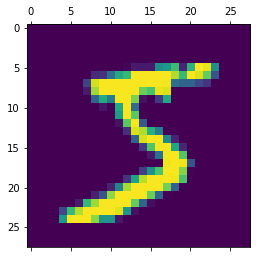

In [7]:
for xi, yi in mnist_train:
    Img = xi.reshape((28, 28))
    plt.matshow(Img.numpy())
    break

Vamos supor que nossa ideia fosse fazer uso de um multiplayer perceptron simples. O mesmo trabalha em cima de uma vetor. Portanto, temos que converter imagem ao carregar. Para isto, podemos fazer uso de um Transformer. Existe um mundo de [Transformers](https://pytorch.org/docs/stable/torchvision/transforms.html). Use o comando help para entender os mesmos.

In [8]:
help(transforms.Compose)
help(transforms.ToTensor)
help(transforms.Resize)
help(transforms.Normalize)

Help on class Compose in module torchvision.transforms.transforms:

class Compose(builtins.object)
 |  Composes several transforms together.
 |  
 |  Args:
 |      transforms (list of ``Transform`` objects): list of transforms to compose.
 |  
 |  Example:
 |      >>> transforms.Compose([
 |      >>>     transforms.CenterCrop(10),
 |      >>>     transforms.ToTensor(),
 |      >>> ])
 |  
 |  Methods defined here:
 |  
 |  __call__(self, img)
 |      Call self as a function.
 |  
 |  __init__(self, transforms)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)

Help on class ToTensor in module torchvision.transforms.transforms:

class ToTensor(builtins.

Vamos supor que você queira trabalhar com uma imagem em float64. Use um transformer!

In [9]:
xi, yi = next(iter(mnist_train))
print(xi.dtype)
print(type(yi))

torch.float32
<class 'int'>


Podemos criar nossos transformers também! Por baixo são funções simples. Aqui usamos o tipo torch.cuda.FloatTensor porque estamos trabalhando em GPU. Podemos visualizar todos os tipos disponíveis [aqui](https://pytorch.org/docs/stable/tensors.html).

In [0]:
def transform(sample):
    return sample.reshape(28*28).type('torch.cuda.FloatTensor')

custom_transform = transforms.Lambda(transform)

In [11]:
xi_new = transform(xi)
print(xi_new.shape)

torch.Size([784])


Jogamos o transformer no carregamento dos dados e voilà! Aqui é necessário usar uma composição de transformers. Basicamente, dizemos para o código de carregamento realizar as transformações na ordem em que a colocamos na lista que é passada como argumento da função Compose.

In [0]:
transform_pipe = transforms.Compose([transforms.ToTensor(), custom_transform])

mnist_train = datasets.MNIST('/', download=True, train=True, transform=transform_pipe)
mnist_test = datasets.MNIST('/', download=True, train=False, transform=transform_pipe)

In [13]:
for xi, yi in mnist_train:
    print(xi.shape)
    print(xi.dtype)
    break

torch.Size([784])
torch.float32


Com a classe `gluon.data.DataLoader` conseguimos iterar pela base em minibatches. Esta é a ideia para executar um Minibatch-GD (abaixo).

In [0]:
mnist_train = datasets.MNIST('/', download=True, train=True, transform=transform_pipe)
mnist_test = datasets.MNIST('/', download=True, train=False, transform=transform_pipe)

In [0]:
minibatch_train = torch.utils.data.DataLoader(mnist_train, batch_size=50)
minibatch_test = torch.utils.data.DataLoader(mnist_test, batch_size=50)

In [16]:
for xi, yi in minibatch_train:
    print(xi.shape) # note como carregamos 50 vetores de tamanho 784
    print(xi.dtype)
    break

torch.Size([50, 784])
torch.float32


Uma prática comum que você pode ter nos seus dados é criar pastas de imagem de treino, teste e validação. Não temos isto pronto no notebook mas seria algo como o código abaixo. Note o uso de um `torchvision.datasets.ImageFolder`.

```python
# loading the data and apply pre-processing(transforms) on images
train_data = torch.utils.data.DataLoader(
    datasets.ImageFolder(train_path), transform=transformer,
    batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_data = torch.utils.data.DataLoader(
    datasets.ImageFolder(val_path), transform=transformer,
    batch_size=batch_size, shuffle=False, num_workers=num_workers)

test_data = torch.utils.data.DataLoader(
    datasets.ImageFolder(test_path), transform=transformer,
    batch_size=batch_size, shuffle=False, num_workers=num_workers)
```

## Passo 2: Definir a arquitetura

Um modelo deve ser definido para ser treinado usando os dados desejados.
No caso de redes neurais, criaremos uma nova arquitetura.
Tal arquitetura pode ser composta de diversos tipos de camadas como, por exemplo, [Densas ou Lineares](https://pytorch.org/docs/stable/nn.html#linear) (camadas totalmente conectadas como as que implementamos do zero), [convolucionais](https://pytorch.org/docs/stable/nn.html#convolution-layers), e [recorrentes](https://pytorch.org/docs/stable/nn.html#recurrent-layers).
Veremos todas essas camadas ao longo do curso.

Primeiramente definimos uma função que faz a inicialização dos parâmetros da rede.

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.01) # valores iniciais são uma normal

O código abaixo cria uma rede simples MLP. Note como a mesma tem 10 saídas. A entrada é definida, que é o formato que transformamos nossa imagem de entrada.

In [19]:
net = nn.Sequential(
    nn.Linear(784, 10)
)

net.apply(weights_init) # aplica a função de inicialização às camadas da rede

Sequential(
  (0): Linear(in_features=784, out_features=10, bias=True)
)

## Passo 3: Definir a função de custo (função de perda ou *loss*)

Funções de perda, também conhecidas como *loss functions*, são muito importantes para o aprendizagem de máquinas, pois servem como uma forma de medir a distância ou a diferença entre a saída prevista de um modelo e o seu valor real, auxiliando então no treino no modelo.

Diversas funções de perda foram propostas ao longo do tempo para diferentes tipos de problemas.
Algumas dessas funções foram propostas para auxiliar no treino de modelos de regressão linear, como a *loss* [L1](https://pytorch.org/docs/stable/nn.html#l1loss).
Já outras foram propostas para problemas de classificação, como [Hinge](https://pytorch.org/docs/stable/nn.html#hingeembeddingloss), e [Cross Entropy](https://pytorch.org/docs/stable/nn.html#crossentropyloss).

Veremos várias funções de custo mais adiante no curso.
Neste primeiro momento, focaremos na função [Cross Entropy](https://pytorch.org/docs/stable/nn.html#crossentropyloss) combinada com a ativação [Softmax](https://pytorch.org/docs/stable/nn.html#softmax), pois é a combinação mais comum nos dias de hoje para a tarefa de classificação.

O pequeno bloco de código abaixo implementa essa função de perda em torch.

In [0]:
# função de custo (ou loss)
cross_entropy = nn.CrossEntropyLoss()

## Passo 4: Definir o algoritmo de otimização

Definimos uma arquitetura, composta de diversos pesos geralmente inicializados aleatoriamente, e definimos também uma função que custo que nos permite avaliar o quão bem esta rede neural está.
Entretanto, para que possamos alterar os pesos e fazer a rede convergir para um bom resultados, devemos definir um algoritmo de otimização, que usará derivadas parciais da função de custo em relação àos pesos para otimizar a rede.

Diversos algoritmos foram propostos ao longo dos anos como, por exemplo, Stochastic Gradient Descent (SGD), Adam, e RMSProp.
Veremos mais adianta sobre cada um desses algoritmos.
Nesse primeiro momento, usaremos o algoritmo mais comum: Stochastic Gradient Descent (SGD). A documentação de como usar esses diferentes otimizadores com o torch pode ser encontrada [aqui](https://pytorch.org/docs/stable/optim.html#algorithms).

O código abaixo implementa uma função de otimização usando o SGD para otimizar todos os parâmetros da rede neural proposta.

In [0]:
# trainer do torch
lr = 0.5
trainer = optim.SGD(net.parameters(), lr=lr)

### Treinando

A partir deste momento já podemos treinar! Observe como a biblioteca permite de forma muito simples uma implementação do gradiente descendente

In [0]:
# 1. Carrega dados
mnist_train = datasets.MNIST('/', download=True, train=True, transform=transform_pipe)
mnist_test = datasets.MNIST('/', download=True, train=False, transform=transform_pipe)

# 2. Define mini-batch
minibatch_train = torch.utils.data.DataLoader(mnist_train, batch_size=50)
minibatch_test = torch.utils.data.DataLoader(mnist_test, batch_size=50)

# 3. Define rede

net = nn.Sequential(
    nn.Linear(784, 10)
)

net.apply(weights_init)
net.to(device) # diz para a rede que ela deve ser treinada na GPU

# 4. Define loss e treinamento
cross_entropy = nn.CrossEntropyLoss()
lr = 0.01
trainer = optim.SGD(net.parameters(), lr=lr)

Agora, treine!

In [23]:
iteracoes_treino = 5
for i in range(iteracoes_treino):         # número de iterações, não verificamos convergencia
    cumulative_loss = 0
    for data, y in minibatch_train:       # para cada minibatch
        data, y = data.to(device), y.to(device)

        trainer.zero_grad()

        P = net(data)                     # execute o softmax, retorne as probabilidades, forward
        loss = cross_entropy(P, y)        # compute a perda
        loss.backward()                   # atualiza os pesos com backward, nosso backprop de antes
        trainer.step()                    # atualize os parâmetros com a derivada
        cumulative_loss += loss.item()
    print('Iteração {}. Perda {}'.format(i, cumulative_loss / len(data)))

Iteração 0. Perda 21.470576854646207
Iteração 1. Perda 12.254552741646767
Iteração 2. Perda 10.632046619057656
Iteração 3. Perda 9.832181369662285
Iteração 4. Perda 9.331509895175696


Podemos treinar aquiteturas mais complicadas. Abaixo, treinaremos uma arquitetura baseada na [LeNet-5](https://ieeexplore.ieee.org/document/726791).

Notem que, além de definir o tipo da camada, é necessário também definir a sua ativação.
Existem diversos tipos de ativações como, por exemplo, [ReLU](https://pytorch.org/docs/stable/nn.html#relu), [LeakyReLU](https://pytorch.org/docs/stable/nn.html#leakyrelu), e [sigmoid](https://pytorch.org/docs/stable/nn.html#sigmoid).
Neste primeiro momento, usaremos somente a ReLU.
Porém, veremos mais de perto várias outras ativações ao longo deste curso.

O trecho de código abaixo implementa uma rede simples usando [ReLUs](https://pytorch.org/docs/stable/nn.html#relu) no framework torch.

In [0]:
# 1. Carrega dados
mnist_train = datasets.MNIST('/', download=True, train=True, transform=transform_pipe)
mnist_test = datasets.MNIST('/', download=True, train=False, transform=transform_pipe)

# 2. Define mini-batch
minibatch_train = torch.utils.data.DataLoader(mnist_train, batch_size=50)
minibatch_test = torch.utils.data.DataLoader(mnist_test, batch_size=50)

# 3. Define rede

net = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

net.apply(weights_init)
net.to(device) # diz para a rede que ela deve ser treinada na GPU

# 4. Define loss e treinamento
cross_entropy = nn.CrossEntropyLoss()
lr = 0.01
trainer = optim.SGD(net.parameters(), lr=lr)

Observe como nessa rede nova a perda é bem menor logo de cara, parece melhor!

In [25]:
iteracoes_treino = 5
for i in range(iteracoes_treino):         # número de iterações, não verificamos convergencia
    cumulative_loss = 0
    for data, y in minibatch_train:       # para cada minibatch
        data, y = data.to(device), y.to(device) 

        trainer.zero_grad()

        P = net(data)                     # execute o softmax, retorne as probabilidades, forward
        loss = cross_entropy(P, y)        # compute a perda
        loss.backward()                   # atualiza os pesos com backward, nosso backprop de antes
        trainer.step()                    # atualize os parâmetros com a derivada
        cumulative_loss += loss.item()
    print('Iteração {}. Perda {}'.format(i, cumulative_loss / len(data)))

Iteração 0. Perda 55.23879845142365
Iteração 1. Perda 55.138643593788146
Iteração 2. Perda 50.74311968564987
Iteração 3. Perda 26.898302388191222
Iteração 4. Perda 15.673906292915344


Abaixo rodamos um minibatch apenas. Note como a rede gera previsões. Para cada instância, temos 10 elementos da camada final. A probabilidade de cada classe!

In [26]:
for data, y in minibatch_test: 
    P = net(data)                # faça uma previsão
    print(P.shape)
    break

torch.Size([50, 10])


Abaixo avaliamos a acurácia no teste.

In [0]:
i = 0
with torch.no_grad():
    for data, y in minibatch_test:            # para cada minibatch do teste
        P = net(data.to(device))              # faça uma previsão
        _, predicted = torch.max(P, 1)        # pegue a classe mais provavel
        c = (predicted == labels).squeeze()
    
print(acc)

EvalMetric: {'accuracy': 0.1028}


## Passo 5: Colando Tudo Junto


No geral, não vamos fazer isso sempre do zero. 

Portanto, abaixo implementamos algumas funções auxiliares. As mesmas carregam os dados, quebram treinam e validam, reportam métricas. Vamos usar elas nos outros notebooks.

Portanto, criamos conjuntos de treino/validação. Este é último passo para então treinar a rede neural. Abixo, temos uma função que que recebe os dados, a rede, o *loss*, e o algoritmo de otimização, e realmente converge o modelo.

In [0]:
## carregando dados

# código para carregar o dataset do MNIST
# http://yann.lecun.com/exdb/mnist/
def load_data_mnist(batch_size, resize=None, root=os.path.join(
        '~', '.pytorch', 'datasets', 'fashion-mnist')):
    """Download the Fashion-MNIST dataset and then load into memory."""
    root = os.path.expanduser(root)
    transformer = []
    if resize:
        transformer += [transforms.Resize(resize)]
    transformer += [transforms.ToTensor()]
    transformer = transforms.Compose(transformer)

    mnist_train = datasets.MNIST(root=root, train=True,download=True, transform=transformer)
    mnist_test = datasets.MNIST(root=root, train=False,download=True, transform=transformer)
    num_workers = 0 if sys.platform.startswith('win32') else 4



    train_iter = torch.utils.data.DataLoader(mnist_train,
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = torch.utils.data.DataLoader(mnist_test,
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)
    return train_iter, test_iter

# funções básicas
def _get_batch(batch):
    """Return features and labels on ctx."""
    features, labels = batch
    if labels.type() != features.type():
        labels = labels.type(features.type())
    return (torch.nn.DataParallel(features, device_ids=devices_ids),
            torch.nn.DataParallel(labels, device_ids=devices_ids), features.shape[0])

# Função usada para calcular acurácia
def evaluate_accuracy(data_iter, net, loss):
    """Evaluate accuracy of a model on the given data set."""

    acc_sum, n, l = torch.Tensor([0]), 0, 0
    
    with torch.no_grad():
      for X, y in data_iter:
          #y = y.astype('float32')
          X, y = X.to(device), y.to(device)
          y_hat = net(X)
          l += loss(y_hat, y).sum()
          acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
          n += y.size()[0]

    return acc_sum.item() / n, l.item() / len(data_iter)
  
# Função usada no treinamento e validação da rede
def train_validate(net, train_iter, test_iter, batch_size, trainer, loss,
                   num_epochs):
    print('training on', device)
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            trainer.zero_grad()
            l = loss(y_hat, y).sum()
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.size()[0]
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss)
        print('epoch %d, train loss %.4f, train acc %.3f, test loss %.4f, '
              'test acc %.3f, time %.1f sec'
              % (epoch + 1, train_l_sum / len(train_iter), train_acc_sum / n, test_loss, 
                 test_acc, time.time() - start))

In [0]:
# carregamento do dado: mnist
batch_size = 256
train_iter, test_iter = load_data_mnist(batch_size)

In [0]:
net = nn.Sequential(
    nn.Flatten(), # Camada para transformar a imagem 2D em um vetor 1D
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

net.apply(weights_init)
net.to(device)

cross_entropy = nn.CrossEntropyLoss()
lr = 0.01
trainer = optim.SGD(net.parameters(), lr=lr)

In [39]:
num_epochs = 10
train_validate(net, train_iter, test_iter, batch_size, trainer, cross_entropy, num_epochs)

training on cuda
epoch 1, train loss 2.3029, train acc 0.112, test loss 2.3028, test acc 0.114, time 6.7 sec
epoch 2, train loss 2.3020, train acc 0.112, test loss 2.3019, test acc 0.114, time 6.8 sec
epoch 3, train loss 2.3014, train acc 0.112, test loss 2.3013, test acc 0.114, time 6.8 sec
epoch 4, train loss 2.3009, train acc 0.112, test loss 2.3008, test acc 0.114, time 6.8 sec
epoch 5, train loss 2.3005, train acc 0.112, test loss 2.3002, test acc 0.114, time 6.8 sec
epoch 6, train loss 2.2999, train acc 0.112, test loss 2.2996, test acc 0.114, time 6.8 sec
epoch 7, train loss 2.2992, train acc 0.112, test loss 2.2987, test acc 0.114, time 6.8 sec
epoch 8, train loss 2.2982, train acc 0.112, test loss 2.2973, test acc 0.114, time 6.8 sec
epoch 9, train loss 2.2964, train acc 0.112, test loss 2.2949, test acc 0.114, time 6.8 sec
epoch 10, train loss 2.2931, train acc 0.114, test loss 2.2901, test acc 0.128, time 6.8 sec
